# Network Intrusion Detection Using Machine Learning/Deep Learning
This notebook involves the making of machine learning & deep learning models to classify the given data of obtained as a network intrusion into differen classes (malignant or benign). Given a sample point, the objective of machine learning model will be to classify that whether the intrusion made is  **Benign** or is a **BruteForce** (either FTP or SSH).

In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [2]:
# check the available data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ids-intrusion-csv/02-28-2018.csv
/kaggle/input/ids-intrusion-csv/03-01-2018.csv
/kaggle/input/ids-intrusion-csv/02-16-2018.csv
/kaggle/input/ids-intrusion-csv/02-15-2018.csv
/kaggle/input/ids-intrusion-csv/02-21-2018.csv
/kaggle/input/ids-intrusion-csv/03-02-2018.csv
/kaggle/input/ids-intrusion-csv/02-22-2018.csv
/kaggle/input/ids-intrusion-csv/02-20-2018.csv
/kaggle/input/ids-intrusion-csv/02-14-2018.csv
/kaggle/input/ids-intrusion-csv/02-23-2018.csv
/kaggle/input/rapids/rapids.0.18.0
/kaggle/input/rapids/rapids.0.19.0
/kaggle/input/rapids/rapids.0.17.0
/kaggle/input/rapids/rapids.21.06


In [3]:
!nvidia-smi

Fri Nov  4 16:31:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%time
# load the data into memory
network_data = pd.read_csv('../input/ids-intrusion-csv/02-14-2018.csv')

CPU times: user 5.86 s, sys: 1.05 s, total: 6.9 s
Wall time: 10.8 s


In [5]:
# check the shape of data
network_data.shape

(1048575, 80)

In [6]:
# check the number of rows and columns
print('Number of Rows (Samples): %s' % str((network_data.shape[0])))
print('Number of Columns (Features): %s' % str((network_data.shape[1])))

Number of Rows (Samples): 1048575
Number of Columns (Features): 80


In [7]:
network_data.head(4)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [8]:
# check the columns in data
network_data.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [9]:
# check the number of columns
print('Total columns in our data: %s' % str(len(network_data.columns)))

Total columns in our data: 80


The dataset is huge. We have a total of **80** columns in our data.

In [10]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [11]:
# check the number of values for labels
network_data['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [ ]:
# make a scatterplot
pyo.init_notebook_mode()
fig = px.scatter(x = network_data["Bwd Pkts/s"][:100000], 
                 y=network_data["Fwd Seg Size Min"][:100000])
fig

In [ ]:
%%time
sns.set(rc={'figure.figsize':(12, 6)})
sns.scatterplot(x=network_data['Bwd Pkts/s'][:50000], y=network_data['Fwd Seg Size Min'][:50000], 
                hue='Label', data=network_data)

In [ ]:
# check the dtype of timestamp column
(network_data['Timestamp'].dtype)

In [ ]:
# check for some null or missing values in our dataset
network_data.isna().sum().to_numpy()

In [ ]:
# drop null or missing columns
cleaned_data = network_data.dropna()
cleaned_data.isna().sum().to_numpy()

In [ ]:
# encode the column labels
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()

In [ ]:
# check for encoded labels
cleaned_data['Label'].value_counts()

In [ ]:
# make 3 seperate datasets for 3 feature labels
data_1 = cleaned_data[cleaned_data['Label'] == 0]
data_2 = cleaned_data[cleaned_data['Label'] == 1]
data_3 = cleaned_data[cleaned_data['Label'] == 2]

# make benign feature
y_1 = np.zeros(data_1.shape[0])
y_benign = pd.DataFrame(y_1)

# make bruteforce feature
y_2 = np.ones(data_2.shape[0])
y_bf = pd.DataFrame(y_2)

# make bruteforceSSH feature
y_3 = np.full(data_3.shape[0], 2)
y_ssh = pd.DataFrame(y_3)

# merging the original dataframe
X = pd.concat([data_1, data_2, data_3], sort=True)
y = pd.concat([y_benign, y_bf, y_ssh], sort=True)

In [ ]:
y_1, y_2, y_3

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# checking if there are some null values in data
X.isnull().sum().to_numpy()

In [ ]:
from sklearn.utils import resample

data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)

In [ ]:
train_dataset = pd.concat([data_1_resample, data_2_resample, data_3_resample])
train_dataset.head(2)

In [ ]:
# viewing the distribution of intrusion attacks in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.title('Intrusion Attack Type Distribution')
plt.pie(train_dataset['Label'].value_counts(), labels=['Benign', 'BF', 'BF-SSH'], colors=['blue', 'magenta', 'cyan'])
p = plt.gcf()
p.gca().add_artist(circle)

## Making X & Y Variables (CNN)

In [ ]:
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

In [ ]:
y_train = to_categorical(target_train, num_classes=3)
y_test = to_categorical(target_test, num_classes=3)

In [ ]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

In [ ]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# reshape the data for CNN
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

In [ ]:
# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

In [35]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=30, batch_size=32, 
          validation_data=(X_test, y_test), callbacks=[logger])

1875/1875 [==============================] - 16s 4ms/step - loss: 0.1293 - accuracy: 0.9553 - val_loss: 0.3843 - val_accuracy: 0.8663
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0863 - accuracy: 0.9731 - val_loss: 0.5959 - val_accuracy: 0.7662
Epoch 3/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0792 - accuracy: 0.9745 - val_loss: 0.5823 - val_accuracy: 0.7692
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0757 - accuracy: 0.9757 - val_loss: 0.4513 - val_accuracy: 0.9212
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0790 - accuracy: 0.9761 - val_loss: 1.9005 - val_accuracy: 0.4403
Epoch 6/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0723 - accuracy: 0.9771 - val_loss: 0.8248 - val_accuracy: 0.7638
Epoch 7/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0711 - accuracy: 0.9772 - val_loss: 0.6229 - val_accuracy: 0.8312
Ep

## Visualization of Results (CNN)
Let's make a graphical visualization of results obtained by applying CNN to our data.

In [36]:
# check the model performance on test data
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

188/188 [==============================] - 1s 3ms/step - loss: 0.0066 - accuracy: 0.9970
accuracy: 99.70%


In [37]:
# check history of model
history = his.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

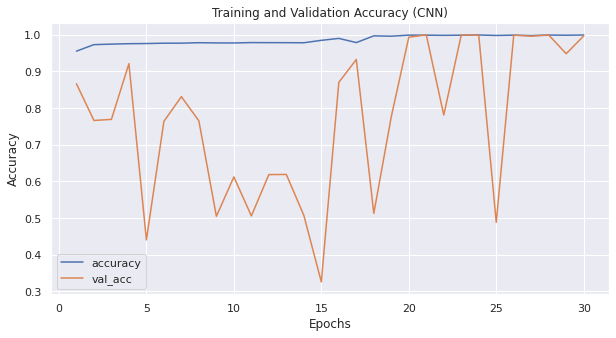

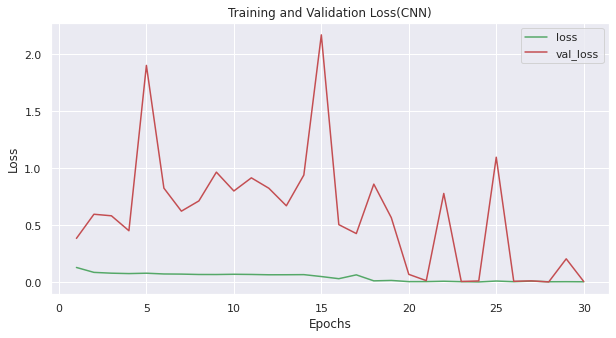

In [38]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [39]:
model.save("CNN_IDS.h5")

In [40]:
import pickle

In [42]:
with open('IDS_CNN_model_pkl', 'wb') as files:
    pickle.dump(model, files)

TypeError: can't pickle weakref objects